### Exponential Thermal Tensor Network Renormalization Group (XTRG)

Date: <span style = "color: wheat"> 23.07.2025 </span> | Author of the code: <span style = "color: wheat"> Matthias Pawlik, Damiano Aliverti </span>

The Exponential Tensor Renormalization Group (XTRG) is a powerful numerical method for computing the thermal density matrix $\hat{\rho} = e^{− \beta \hat{H}}$ of finite-size quantum systems, where $\beta$ is the inverse temperature and $\hat{H}$ is the many-body Hamiltonian. In this problem, you will implement the XTRG algorithm and use it to compute the partition function of a one-dimensional ($1\text{D}$) XY model from high temperatures ($\beta \sim 10^{−6}$) down to low temperatures ($\beta \sim 1$).

<span style = "color: wheat"> [1]  </span> B.-B. Chen, L. Chen, Z. Chen, W. Li, and A. Weichselbaum, Phys. Rev. X 8, 031082 (2018), https://doi.org/10.1103/PhysRevX.8.031082.

<span style = "color: wheat"> (a) </span> Initialize the thermal density matrix as a matrix product operator (MPO) using linear initialization, $\rho(\beta_0) \approx \mathbb{I} − \beta_0 H$, as described in Appendix C.2 of Ref. [1]. Use $\beta_0 = 10^{−6}$ as the initial inverse temperature.

We define the Hamiltonian of the spin-$\frac{1}{2}$ XY-chain of length $\mathcal{L}$ with open boundary conditions (OPC) to $\hat{H} = J \sum_{l = 1}^{\mathcal{L}-1} (\hat{S}^x_l \hat{S}^x_{l+1} + \hat{S}^y_l \hat{S}^y_{l+1}) \equiv J \sum_{l = 1}^{\mathcal{L}-1} (\hat{S}^+_l \hat{S}^-_{l+1} + \hat{S}^-_l \hat{S}^+_{l+1})$.

<span style = "color: SkyBlue"> Solution: </span>

In [9]:
include("source/MPO.jl")
using .MPO

In [10]:
function linear_initialization(L::Int; J::Float64=1.0, beta0::Float64=1e-6)

    # Generate the MPO Hamiltonian for the XY-Model
    H_mpo = xychain_mpo(L, J)

    # Construct an MPO representation of the identity operator
    Id_mpo = identity_mpo(L)

    # Multiply H with inverse initial temperature
    H_mpo = [(beta0 + 0im)^(1/L) * W for W in H_mpo]
    
    # Add the MPOs and obtain new local tensors with bond dimension D = 4 + 1
    rho0 = add_mpo(H_mpo, Id_mpo)

    return rho0, H_mpo

end

linear_initialization (generic function with 1 method)

<span style = "color: wheat"> (b) </span> Implement the XTRG algorithm following the strategy in Sec. II of Ref.[1]. The key idea is to
iteratively double the inverse temperature, $\rho(2 \beta) = \rho(\beta) \times \rho(\beta)$, by contracting the MPO with itself. After each multiplication, the MPO bond dimension increases and must be truncated. This can be done variationally using DMRG-type sweeping, as detailed in Appendix D of Ref. [1].

<span style = "color: SkyBlue"> Solution: </span>

In [11]:
include("source/XTRG.jl")
using .XTRG

<span style = "color: wheat"> (c) </span> Apply your XTRG implementation to the 1D XY-model of length $L = 10$. Perform $20$ XTRG
steps starting from $\beta_0 = 10^{−6}$, so that the final inverse temperature is $\beta = 2^{20} \beta_0$. At each step, compute the partition function $Z = \text{Tr}(\rho(\beta))$. Compare your numerical results with the analytical solution provided in Appendix F of Ref. [1] over the full temperature range.

<span style = "color: SkyBlue"> Solution: </span>

In [12]:
# Parameter setting
L = 10
beta0 = 1e-6
Nsteps = 23
square = false

# Linear initialization 
rho0, H_mpo = linear_initialization(L);

# Execute the XTRG Algorithm
betas, Zs, rho, sing_value_lists = XTRG_algorithm(beta0, Nsteps, rho0, square = square);

# # # Started Variational Optimization # # #
Temperature update: 1.0e-6 ---> 2.0e-6
>>> # of sites = 10
>>> square mode = false
>>> # of sweeps = 5 x 2
>>> convergence = 1.0e-8
>>> Dmax = 75
>>> alpha = 1.5
>>> Nkeep = 8
>>> tolerance = 1.0e-8
Completed right-left sweep 1 / 5
Completed left-right sweep 1 / 5
Completed right-left sweep 2 / 5
Completed left-right sweep 2 / 5
Completed right-left sweep 3 / 5
Completed left-right sweep 3 / 5
Completed right-left sweep 4 / 5
Completed left-right sweep 4 / 5
Completed right-left sweep 5 / 5
Completed left-right sweep 5 / 5
Convergence successful: true


# # # Started Variational Optimization # # #
Temperature update: 2.0e-6 ---> 4.0e-6
>>> # of sites = 10
>>> square mode = false
>>> # of sweeps = 5 x 2
>>> convergence = 1.0e-8
>>> Dmax = 75
>>> alpha = 1.5
>>> Nkeep = 4
>>> tolerance = 1.0e-8
Completed right-left sweep 1 / 5
Completed left-right sweep 1 / 5
Completed right-left sweep 2 / 5
Completed left-right sweep 2 / 5
Completed right-lef

In [13]:
# Analytical solution for the partition function of the XY-Model with OBC

function partition_function_analytical(beta, L, J=1.0)
    Z = 1.0
    for k in 1:L
        epsilon_k = J * cos(k * pi / (L + 1))
        Z *= (1 + exp(-beta * epsilon_k))
    end
    return Z 
end

partition_function_analytical (generic function with 2 methods)

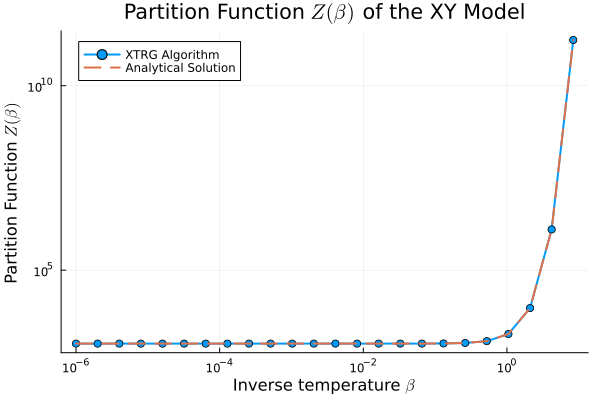

In [14]:
include("source/plotting.jl")
using .plotting

# Compute analytical values for simulated inverse temperatures
Zs_analytical = [partition_function_analytical(beta, L) for beta in betas]

# Call the plotting function
plot_partition_function(betas, Zs, Zs_analytical)

As an aside, we can search for qualitative patterns in the singular values coming from the two-site updates, as a function of $\beta$. More specifically, at each XTRG step `n` of the algorithm (i.e. for each $\beta$), we have stored in `sing_value_lists[n + 1][itL]` the vector of singular values obtained after the update of sites `itL` and `itL + 1`, during the last (left->right) sweep within the `n`th XTRG step. In short, all these singular values are $\beta$-dependent quantities whose dependence on $\beta$ might have certain patterns. Unveiling such patterns might then lead to ideas to make the XTRG algorithm more efficient. 

Here we display the largest 7 *nonvanishing* singular values at different sites across the chain, when available, as a function of $\beta$. We normalize singular values such that they add up to unity. We observe that the second and third singular values coincide due due to some symmetry.

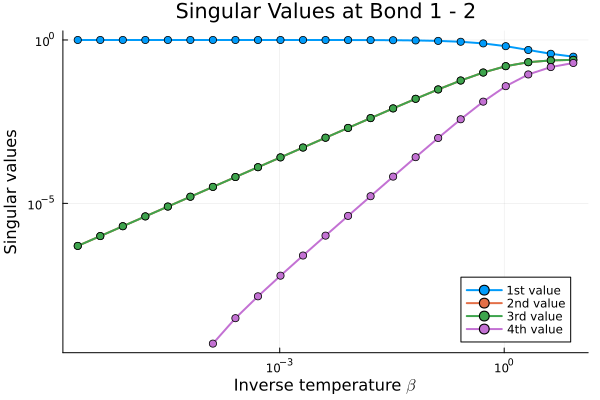

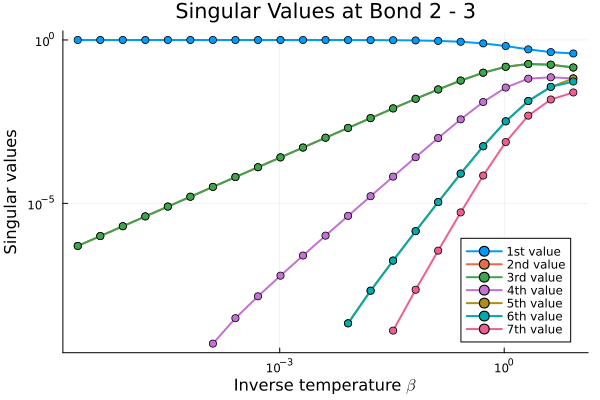

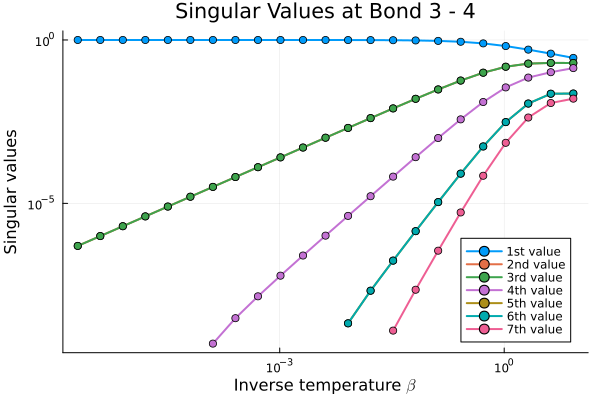

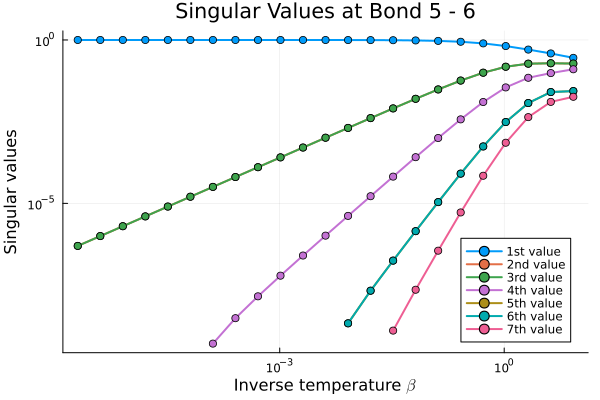

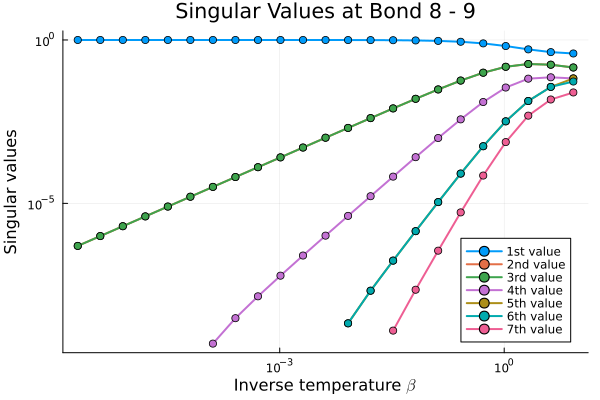

In [15]:
n_sing_values = 7
site_indices = [1, 2, 3, 5, 8]
for site_index in site_indices
    plot_singular_values(betas, sing_value_lists, site_index, n_sing_values)
end